# Import Packages

In [185]:
"""
Main File for QRT - Electricity Price - 2023 Project
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr

from xgboost import XGBRegressor
from xgboost import plot_importance

# Useful Functions

In [186]:
def plot_ts(ts_x: pd.Series, ts_y: pd.Series, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts_x, ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()


def metric_train(output, Y_clean):
    return spearmanr(output, Y_clean).correlation

# Data Preprocessing

In [187]:
# Importing Data From Files
curr_dir = '/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/'
os.chdir(curr_dir)

X = pd.read_csv(f"{curr_dir}data/X_train_NHkHMNU.csv").set_index('ID').sort_values(by='DAY_ID')
X = X.fillna(method='ffill')  # Forward Fill Missing Data
X = X.fillna(method='bfill')  # Backward Fill introduces lookahead bias
X = pd.get_dummies(X, columns=['COUNTRY'])  # One Hot Encoding for each country

y = pd.read_csv(f"{curr_dir}data/y_train_ZAN5mwg.csv").set_index('ID')
#y = pd.merge(X[['ID']], y, on='ID')  # Align the ID column of X and y
y = X.join(y)[['TARGET']] # Align the ID column of X and y


x_validation = pd.read_csv(f"{curr_dir}data/X_test_final.csv").set_index('ID')
x_validation = x_validation.fillna(method='ffill') # Forward Fill the Missing Data
x_validation = x_validation.fillna(method='bfill') # Backward Fill introduces lookahead bias
x_validation = pd.get_dummies(x_validation, columns=['COUNTRY']) # One Hot Encoding for each country

In [188]:
X.head()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
ID,,,,,,,,,,,,,,,,,,,,,
1057,0,0.048418,-0.465067,-0.079296,0.079296,0.405549,0.650577,-0.405549,-0.650577,0.592572,...,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,False,True
1179,1,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,...,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,False,True
1327,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,False,True
111,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,True,False
2016,3,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,...,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,False,True


In [189]:
y.head()

,TARGET
ID,
1057,0.108953
1179,-0.063369
1327,2.575976
111,0.861270
2016,0.068905


In [190]:
x_validation.head()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
ID,,,,,,,,,,,,,,,,,,,,,
1115,241,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,-0.519419,1.524963,...,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256,False,True
1202,1214,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,-0.555367,1.064102,...,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086,False,True
1194,1047,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,-0.666901,0.128004,...,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747,False,True
1084,1139,0.172555,-0.723427,-0.044539,0.044539,1.620928,-0.205276,-1.620928,0.205276,1.046069,...,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069,False,True
1135,842,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,0.240856,1.376753,...,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341,False,True


# Missing Data

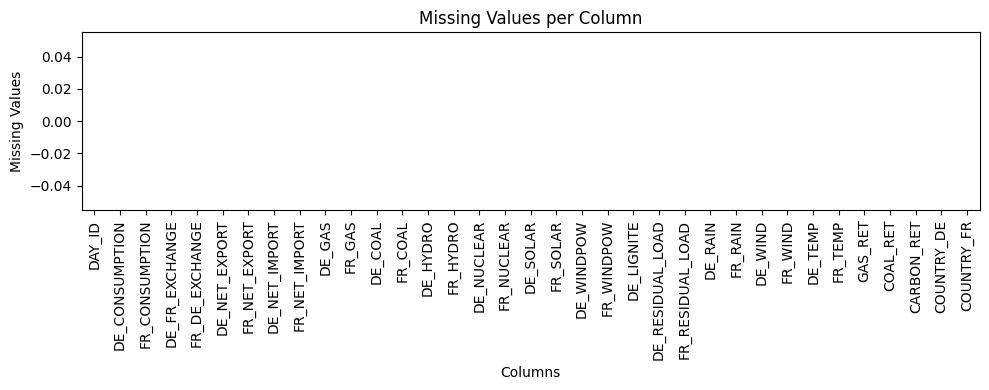

In [191]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

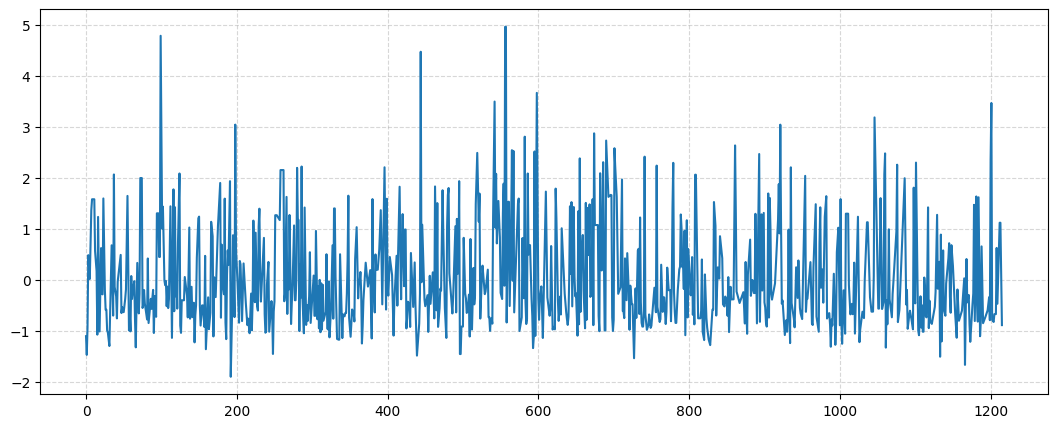

In [192]:
plot_ts(X['DAY_ID'], X['FR_WIND'])

# Fill Data

In [193]:
# Combined Training and Testing Data
# full_data = pd.concat([x_train, x_test], axis=0).sort_index()
# de_full_data = full_data[full_data['COUNTRY'] == 'DE']
# fr_full_data = full_data[full_data['COUNTRY'] == 'FR']

# x_train = x_train.interpolate(method='linear')
# x_test = x_test.interpolate(method='linear')

# Separating data for each country
# de_x_train = x_train[x_train['COUNTRY'] == 'DE']
# de_y_train = y_train[y_train.index.isin(de_x_train.index)]
# fr_x_train = x_train[x_train['COUNTRY'] == 'FR']
# fr_y_train = y_train[y_train.index.isin(fr_x_train.index)]

# XGBoost Regression

In [194]:
# Find best XGB parameters
# Split the training dataset into training and testing sets

X_clean = X
Y_clean = y['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.20, random_state=42)
xg_reg = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                      max_depth=5, alpha=10, n_estimators=10)
# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.947755


In [195]:
# Compare Correlation of the best XGB model and the XGB model on the whole training set
xgb = XGBRegressor()
xgb.fit(X_clean, Y_clean)
output_train = xgb.predict(X_clean)
new_output = xg_reg.predict(X_clean)

print('Spearman correlation for the train set: {:.1f}%'.format(
    100 * metric_train(output_train, Y_clean)))
print('New Model Spearman correlation for the train set: {:.1f}%'.format(
    100 * metric_train(new_output, Y_clean)))

Spearman correlation for the train set: 97.1%
New Model Spearman correlation for the train set: 42.3%


In [196]:
X_validation_clean = x_validation

Y_test_submission = pd.DataFrame()
Y_test_submission['ID'] = x_validation.index.to_list()
Y_test_submission['TARGET'] = xgb.predict(X_validation_clean)

Y_test_submission.to_csv('src/xgb_predictions.csv', index=False)

In [197]:
Y_test_submission

,ID,TARGET
0,1115,0.063145
1,1202,-0.442551
2,1194,0.091037
3,1084,0.076987
4,1135,-0.221982
...,...,...
649,879,-1.116993
650,673,0.856461
651,1641,1.446889
652,712,0.560077


Current out of sample performance is 18.58%. This beats the benchmark Linear Regression Model's performance of 15.9%

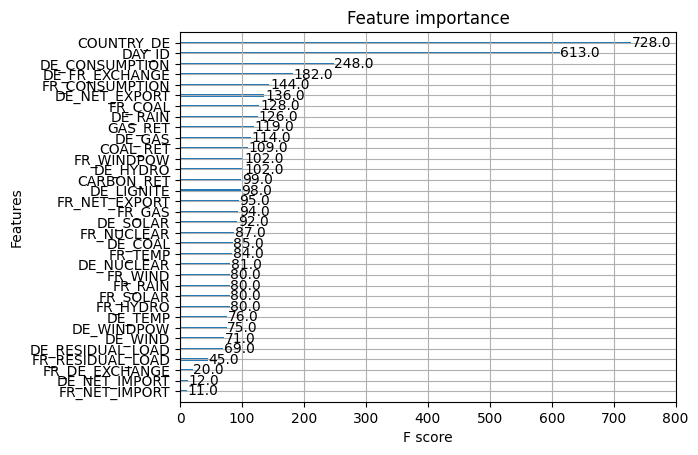

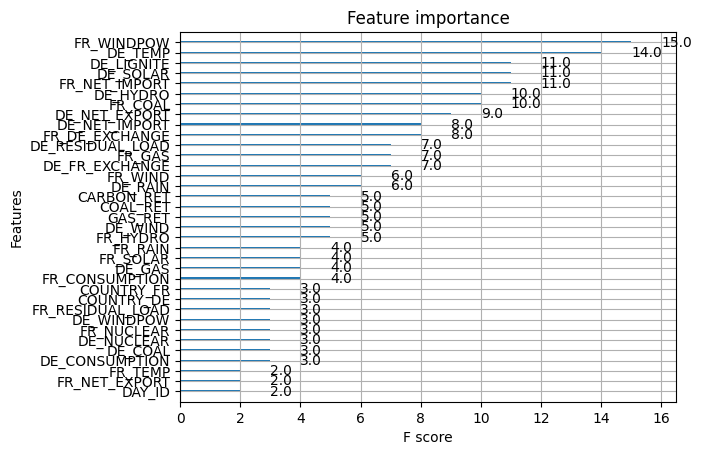

In [198]:
# Feature importance
base_model_feature_importance = xgb.feature_importances_
new_model_feature_importance = xg_reg.feature_importances_

# Plot feature importance
plot_importance(xgb)
plot_importance(xg_reg)
plt.show()

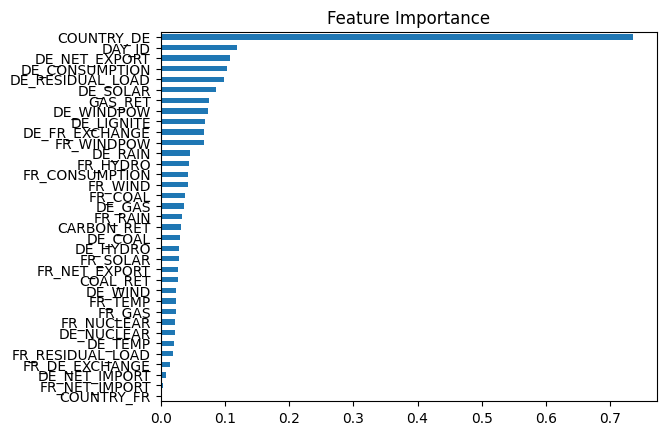

In [199]:
# Perform permutation importance
results = permutation_importance(
    xgb, X_train, y_train, n_repeats=10, random_state=42)

# Get importance scores
importance_scores = results.importances_mean

# Organize and plot the importance scores
importances = pd.Series(importance_scores, index=X_train.columns)
importances = importances.sort_values()

importances.plot(kind='barh')
plt.title('Feature Importance')
plt.show()

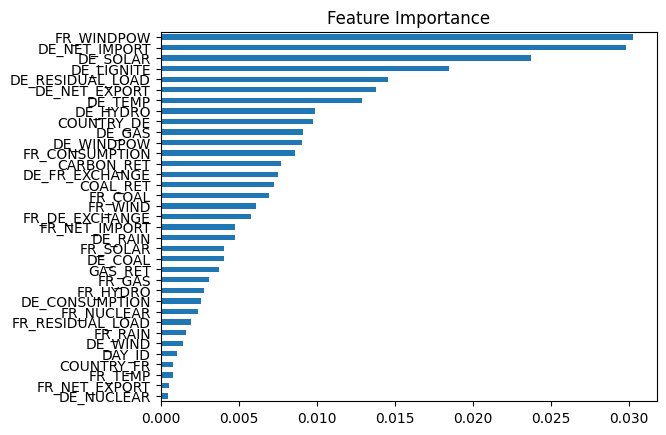

In [200]:
# Perform permutation importance
results = permutation_importance(
    xg_reg, X_train, y_train, n_repeats=10, random_state=42)

# Get importance scores
importance_scores = results.importances_mean

# Organize and plot the importance scores
importances = pd.Series(importance_scores, index=X_train.columns)
importances = importances.sort_values()

importances.plot(kind='barh')
plt.title('Feature Importance')
plt.show()